# Lab 5

**Adam Aiken**

March 29th, 2025

# Portfolio Math

## Part 2 - Getting Our Data

In [70]:
import numpy as np
import pandas as pd
import datetime as dt

from datetime import timedelta

import seaborn as sns

# plotting packages
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clrs

import scipy.optimize as sco

mf = pd.read_csv('https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/main/data/mutual_funds.csv')

mf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ticker       529 non-null    object
 1   caldt        529 non-null    int64 
 2   crsp_fundno  529 non-null    int64 
 3   mret         528 non-null    object
dtypes: int64(2), object(2)
memory usage: 16.7+ KB


VMVFX is forms portfolios that try to minimize the variance of the portfolio of stocks. This is related to the **low risk** style-factor. Essentially, lower risk portfolios do better than you would expect, based on models like the CAPM. In other words, you get more return then you'd think. 

## Part 3 - Cleaning our data

In [71]:
mf['mret'] = pd.to_numeric(mf['mret'], downcast='float', errors='coerce')


## Part 4 - Getting summary stats and more organization

In [72]:
mf.groupby('ticker')['mret'].mean()

ticker
VBMFX    0.002848
VMVFX    0.007720
VTMGX    0.006345
VTSMX    0.012486
Name: mret, dtype: float32

In [73]:
mf = mf.drop('crsp_fundno', axis=1)

In [74]:
mf = pd.pivot(mf, values='mret', columns='ticker', index='caldt').dropna()


In [75]:
mf.head()

ticker,VBMFX,VMVFX,VTMGX,VTSMX
caldt,,,,
20140228,0.004791,0.036561,0.057300,0.047324
20140331,-0.001493,0.006673,-0.004216,0.005138
20140430,0.007719,0.008523,0.015072,0.000633
20140530,0.010478,0.017840,0.016333,0.021712
20140630,0.001096,0.012915,0.010557,0.025378


## Part 5 - Annualized Returns

In [76]:
ann_rets = mf.mean() * 12
ann_rets

ticker
VBMFX    0.030438
VMVFX    0.092639
VTMGX    0.072681
VTSMX    0.148794
dtype: float32

In [77]:
ann_stdev = mf.std() * np.sqrt(12)
ann_stdev

ticker
VBMFX    0.031601
VMVFX    0.101537
VTMGX    0.142306
VTSMX    0.142804
dtype: float32

In [78]:
ann_cov = mf.cov() * 12
ann_cov

ticker,VBMFX,VMVFX,VTMGX,VTSMX
ticker,,,,
VBMFX,0.000999,0.000571,0.000195,0.000011
VMVFX,0.000571,0.010310,0.011837,0.012860
VTMGX,0.000195,0.011837,0.020251,0.017865
VTSMX,0.000011,0.012860,0.017865,0.020393


In [79]:
ann_cor = mf.corr()
ann_cor

ticker,VBMFX,VMVFX,VTMGX,VTSMX
ticker,,,,
VBMFX,1.000000,0.177897,0.043343,0.002341
VMVFX,0.177897,1.000000,0.819231,0.886880
VTMGX,0.043343,0.819231,1.000000,0.879125
VTSMX,0.002341,0.886880,0.879125,1.000000


## Part 12 - An optimal portfolio

This code comes from my notes online. Can you describe what it is doing?

In [80]:
weights = np.array([0.25, 0.25, 0.25, 0.25])

def port_ret(weights):
    return np.sum(ann_rets * weights)

def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(ann_cov, weights)))

def min_func_sharpe(weights):  
    return -port_ret(weights) / port_vol(weights)  

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})  
bnds = tuple((0, 0.5) for x in range(4))  

opts = sco.minimize(min_func_sharpe, weights,
                    method='SLSQP', bounds=bnds,
                    constraints=cons) 

opts

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.2255838704306725
       x: [ 5.000e-01  4.742e-02  5.511e-14  4.526e-01]
     nit: 6
     jac: [-2.997e-01  2.998e-01  1.105e+00  2.997e-01]
    nfev: 30
    njev: 6

You can pull out just a single weight. Which asset is this? Why is the number not exactly 50%?

In [81]:
opts.x[0]

np.float64(0.4999999999997907)

Let's use the functions that we defined above.

In [82]:
port_ret(opts['x']) 

np.float64(0.08695346310268771)

In [83]:
port_vol(opts['x'])  

np.float64(0.07094860270324226)

Now, let's do the portfolio with a target return. Again, you can find this in my notes, under the **efficient frontier** section. The efficient frontier is finding the portfolios that give a particular target return with the least amount of risk (or vice-versa).

No need to define those functions again. Be careful when you copy and paste - you don't want to duplicate a bunch of things. That can make your code very compicated and lead to errors.

All I do is add my target return and an additional constraint.

In [84]:
tret = 0.095

cons = ({'type': 'eq', 'fun': lambda x:  port_ret(x) - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})  
bnds = tuple((0, 0.5) for x in range(4))  

opts = sco.minimize(min_func_sharpe, weights,
                    method='SLSQP', bounds=bnds,
                    constraints=cons) 

opts

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.1779294901746211
       x: [ 4.134e-01  8.655e-02  0.000e+00  5.000e-01]
     nit: 3
     jac: [-2.927e-01  2.201e-01  9.166e-01  2.040e-01]
    nfev: 15
    njev: 3

## Part 6 - An optimal portfolio using PyPortfolioOpt

You need to install PyPortfolioOpt first. I used `pip` in the terminal below.

```
! pip install pyportfolioopt==1.5.5
```

You do need to be careful when install packages. I noticed that this package uninstalls `scipy` and installs an older version. Package dependency is a mess in Python. There are more advanced ways to be doing this using tools like [Docker](https://docs.docker.com/get-started/overview/), [Dev Containers](https://code.visualstudio.com/docs/devcontainers/containers), or [poetry](https://github.com/python-poetry/poetry).

Beyond the scope of our brief time together, but an important part of the software development and statistical computing tool kits.

In [85]:
! pip install pyportfolioopt==1.5.5


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [86]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [87]:
ef = EfficientFrontier(ann_rets, ann_cov, weight_bounds=(0, 0.5))

raw_weights = ef.max_sharpe(risk_free_rate = 0)
raw_weights

OrderedDict([('VBMFX', np.float64(0.5)),
             ('VMVFX', np.float64(0.0471988505521024)),
             ('VTMGX', np.float64(0.0)),
             ('VTSMX', np.float64(0.4528011494478976))])

## Part 7 - Adding data and clustering


In [88]:
# Kmeans algorithm from scikit-learn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

In [89]:
raw = pd.read_csv('https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/main/data/Country_Risk_2019_Data.csv')
raw


,Country,Abbrev,Corruption,Peace,Legal,GDP Growth
0,Albania,AL,35,1.821,4.546,2.983
1,Algeria,DZ,35,2.219,4.435,2.553
2,Argentina,AR,45,1.989,5.087,-3.061
3,Armenia,AM,42,2.294,4.812,6.000
4,Australia,AU,77,1.419,8.363,1.713
...,...,...,...,...,...,...
116,Uruguay,UY,71,1.711,6.329,0.400
117,Vietnam,VI,37,1.877,5.084,6.500
118,Yemen,YE,15,3.369,2.671,2.113
119,Zambia,ZM,34,1.805,4.592,2.021


Venezuela is not included in the 121 countries used in the country risk case study described in this chapter. Its feature values are fairly extreme. The corruption index, peace index, legal risk index,  and real GDP growth rate are 16, 2.671, 2.895, and −35%, respectively. Try adding Venezuela to the countries considered in the three-feature analysis considered in this section. How do the results change? What do your results suggest about the sensitivity of k-means to outliers? 

I'm going to add the new observation to the bottom of the dataframe.

In [90]:
raw.loc[-1] = ['Venezuela', 'VE', 16, 2.671, 2.895, -35.00]  # adding a row
raw.tail()

,Country,Abbrev,Corruption,Peace,Legal,GDP Growth
117,Vietnam,VI,37,1.877,5.084,6.500
118,Yemen,YE,15,3.369,2.671,2.113
119,Zambia,ZM,34,1.805,4.592,2.021
120,Zimbabwe,ZW,24,2.463,3.738,-7.077
-1,Venezuela,VE,16,2.671,2.895,-35.000


We can move it to the top, too. See how we are manipulating the *index*?

In [91]:
raw.index = raw.index + 1  # shifting index
raw = raw.sort_index()  # sorting by index
raw

,Country,Abbrev,Corruption,Peace,Legal,GDP Growth
0,Venezuela,VE,16,2.671,2.895,-35.000
1,Albania,AL,35,1.821,4.546,2.983
2,Algeria,DZ,35,2.219,4.435,2.553
3,Argentina,AR,45,1.989,5.087,-3.061
4,Armenia,AM,42,2.294,4.812,6.000
...,...,...,...,...,...,...
117,Uruguay,UY,71,1.711,6.329,0.400
118,Vietnam,VI,37,1.877,5.084,6.500
119,Yemen,YE,15,3.369,2.671,2.113
120,Zambia,ZM,34,1.805,4.592,2.021


I can sort by a column too. Note how the indices don't change. These are identifying particular rows and move when you sort. 

In [92]:
raw.sort_values(by=['Country'])

,Country,Abbrev,Corruption,Peace,Legal,GDP Growth
1,Albania,AL,35,1.821,4.546,2.983
2,Algeria,DZ,35,2.219,4.435,2.553
3,Argentina,AR,45,1.989,5.087,-3.061
4,Armenia,AM,42,2.294,4.812,6.000
5,Australia,AU,77,1.419,8.363,1.713
...,...,...,...,...,...,...
0,Venezuela,VE,16,2.671,2.895,-35.000
118,Vietnam,VI,37,1.877,5.084,6.500
119,Yemen,YE,15,3.369,2.671,2.113
120,Zambia,ZM,34,1.805,4.592,2.021


By the way, here's another way to add a row.

In [93]:
# Define the new observation
ve_data = {
    'Country': ['Venezuela'],
    'Abbrev': ['VE'],
    'Corruption': [16],
    'Peace': [2.671],
    'Legal': [2.895],
    'GDP Growth': [-35.00]
}

# Create a new DataFrame with the observation
ve_df = pd.DataFrame(ve_data)

# Assume 'raw' is your existing DataFrame
# Concatenate the new DataFrame to the existing one
raw2 = pd.concat([raw, ve_df], ignore_index=True)

I got this code from this ChatGPT prompt. Notice how specific I am:

> I would like to create a dataframe using pandas with the columns [Country,	Abbrev, Corruption,	Peace,	Legal, GDP Growth]. There is then one observation with the values ['Venezuela', 'VE', 16, 2.671, 2.895, -35.00]. I then want to append or concatenate this dataframe to an existing one called raw with the same columns.

Do you see what type *ve_data* is?

In [94]:
type(ve_data)

dict

That's a **dictionary**, not a DataFrame. This is why the code turns it into a DataFrame and then uses `pd.concat` to combine them. 

I can peak at this new data and you'll see the VE observation at the top. 

In [95]:
raw2.head()

,Country,Abbrev,Corruption,Peace,Legal,GDP Growth
0,Venezuela,VE,16,2.671,2.895,-35.000
1,Albania,AL,35,1.821,4.546,2.983
2,Algeria,DZ,35,2.219,4.435,2.553
3,Argentina,AR,45,1.989,5.087,-3.061
4,Armenia,AM,42,2.294,4.812,6.000


I'm going to go back to the original *raw* data set and use that.

In [96]:
df_features = raw[['Peace', 'Legal', 'GDP Growth']]

df_features_scaled = (df_features - df_features.mean()) / df_features.std()

df_features_scaled.head(5)

,Peace,Legal,GDP Growth
0,1.433454,-2.035285,-8.768659
1,-0.400182,-0.849636,0.148881
2,0.458391,-0.929350,0.047927
3,-0.037769,-0.461122,-1.270112
4,0.620183,-0.658611,0.857204


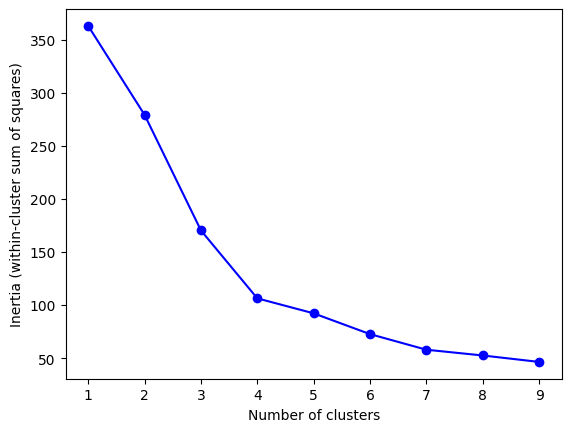

In [97]:
Ks = range(1, 10)
inertia = [KMeans(i).fit(df_features_scaled).inertia_ for i in Ks]

fig = plt.figure()
plt.plot(Ks, inertia, '-bo')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.show()

With one new observation, this looks different that what's in the notes. Let's perform clustering, but use 5 clusters, rather than the three from the notes.

In [98]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=1)
kmeans.fit(df_features_scaled)

# print inertia & cluster center
print("inertia for k=5 is", kmeans.inertia_)
print("cluster centers: ", kmeans.cluster_centers_)

# take a quick look at the result
y = kmeans.labels_
print("cluster labels: ", y)

inertia for k=5 is 94.76116985448208
cluster centers:  [[-1.03672718  1.52765589 -0.15006212]
 [ 1.418181   -0.79149555  0.31257745]
 [ 1.4334541  -2.03528534 -8.76865913]
 [ 0.22258032 -0.48383359 -0.34941107]
 [-0.4488327  -0.06351852  0.42202611]]
cluster labels:  [2 4 3 3 1 0 0 1 3 1 0 4 3 3 4 3 4 1 1 0 1 0 4 1 4 4 4 0 1 0 4 3 1 3 0 1 0
 0 3 4 0 4 3 3 1 4 0 1 4 3 0 1 4 3 0 4 4 1 4 3 4 1 3 4 4 4 4 1 1 4 1 3 3 3
 3 4 0 0 3 1 0 3 1 4 3 3 1 4 0 0 4 1 4 3 4 4 4 0 4 4 3 4 3 0 0 0 4 3 3 3 3
 1 4 1 0 0 0 4 4 1 3 3]


Let's make a plot and see where Venezuala ends up.

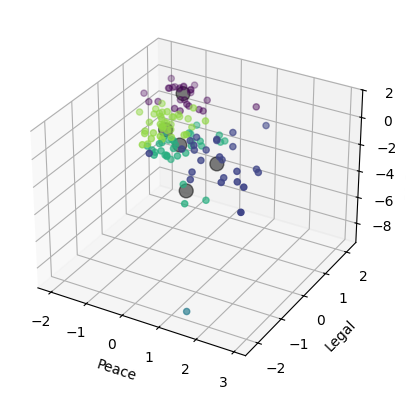

In [99]:
# set up the color
norm = clrs.Normalize(vmin=0.,vmax=y.max() + 0.8)
cmap = cm.viridis

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_features_scaled.iloc[:,0], df_features_scaled.iloc[:,1], df_features_scaled.iloc[:,2], c=cmap(norm(y)), marker='o')

centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)

ax.set_xlabel('Peace')
ax.set_ylabel('Legal')
ax.set_zlabel('GDP Growth')

plt.show()

See that there are five large grey dots now? Those are the centers of our five clusters, each cluster is denoted by a different color.

Let's re-create that graph where each dot is labeled with an abbreviation. I had to edit the list of colors, since we have five clusters, not three. 

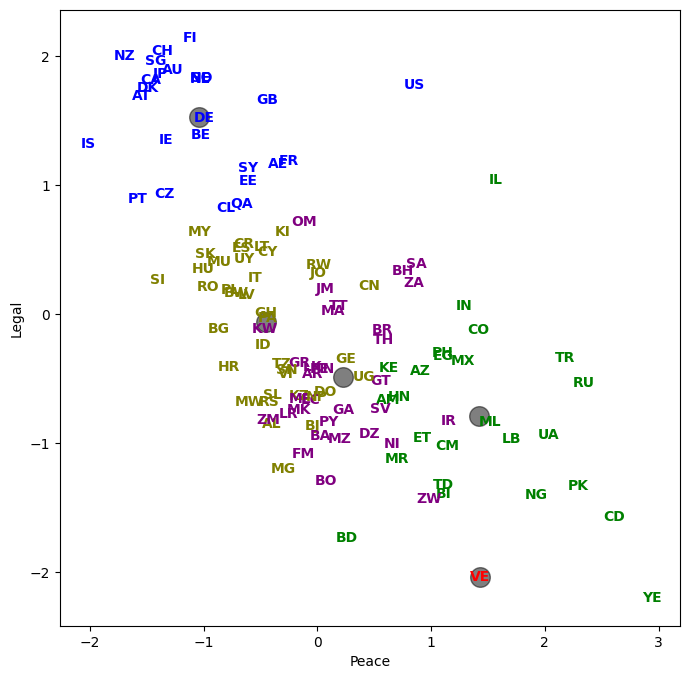

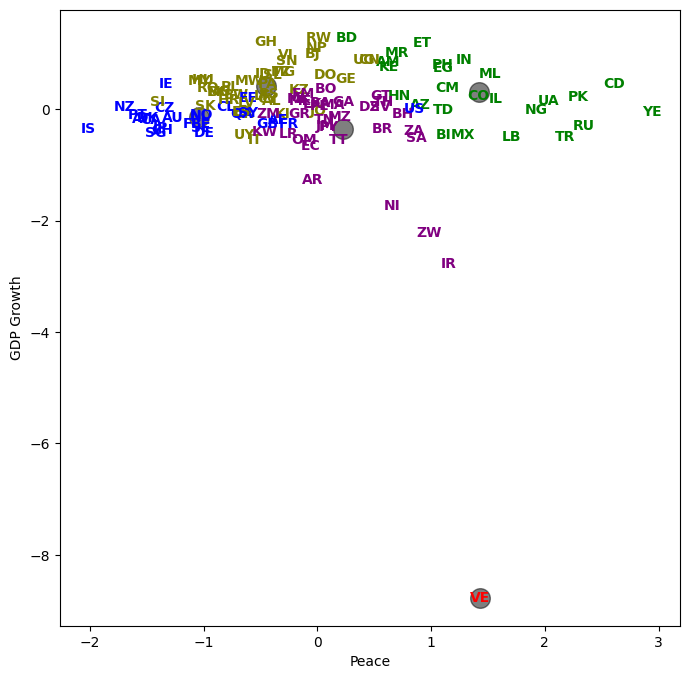

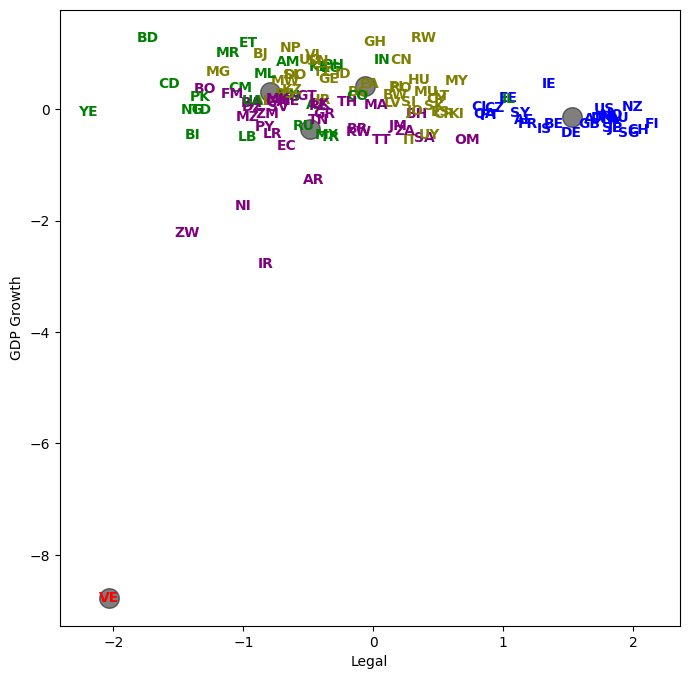

In [100]:
figs = [(0, 1), (0, 2), (1, 2)]
labels = ['Peace', 'Legal', 'GDP Growth']
colors = ['blue', 'green', 'red', 'purple', 'olive']

for i in range(3):
    fig = plt.figure(i, figsize=(8, 8))
    x_1 = figs[i][0]
    x_2 = figs[i][1]
    plt.scatter(df_features_scaled.iloc[:, x_1], df_features_scaled.iloc[:, x_2], c=y, s=0, alpha=0)
    plt.scatter(centers[:, x_1], centers[:, x_2], c='black', s=200, alpha=0.5)
    for j in range(df_features_scaled.shape[0]):
        plt.text(df_features_scaled.iloc[j, x_1], df_features_scaled.iloc[j, x_2], raw['Abbrev'].iloc[j], 
                 color=colors[y[j]], weight='semibold', horizontalalignment = 'center', verticalalignment = 'center')
    plt.xlabel(labels[x_1])
    plt.ylabel(labels[x_2])

plt.show()

Yikes! Venezuala is its own cluster!!!!